## Destination classification

## 1. Importing module

In [323]:
import tensorflow as tf
import numpy as np
import matplotlib as plt

import json


# https://pypi.org/project/vietnam-provinces/

from vietnam_provinces.enums import ProvinceEnum, ProvinceDEnum, DistrictDEnum

## 2. Prepare data

In [324]:
PROVINCES_DICT = {}
i = 0
for member in ProvinceDEnum:
    lowercase = member.value.name.lower()
    PROVINCES_DICT[lowercase] = i
    i += 1
for member in DistrictDEnum:
    lowercase = member.value.name.lower()
    if lowercase.startswith("thành phố"):
        PROVINCES_DICT[lowercase] = i
        i += 1
# Invert the dictionary
PROVINCES_DICT = {value: key for key, value in PROVINCES_DICT.items()}


with open("../data/dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

sentences = []
labels = []



format_data = []


for item in data:
    sentence = item["sentence"]
    label = item["label"]
    sentences.append(sentence)
    labels.append(label)
    label = PROVINCES_DICT[label]
    new_data = {"sentence": sentence, "label": label}
    format_data.append(new_data)

i = 0
for item in format_data:
    if i >= 17:
        print(i, item["sentence"], item["label"], sep="|")
    i += 1

17|Bà Rịa - Vũng Tàu có bãi Trước đẹp lắm, mình muốn ghé.|tỉnh bà rịa - vũng tàu
18|Mình thích đi chơi ở Đồng Nai, có gì hot không nhỉ?|tỉnh đồng nai
19|Lễ hội đèn đỏ ở Chợ Lớn Hồ Chí Minh rất đẹp, bạn đã tham gia chưa?|thành phố hồ chí minh
20|Cần Thơ có nhiều điểm ẩm thực ngon, bạn biết chưa?|thành phố cần thơ
21|Buổi tối ở Đà Nẵng thì nên ghé quán nào để cảm nhận không khí?|thành phố đà nẵng
22|Phong cảnh ở Ninh Bình thơ mộng, mình muốn đến đây ngắm cảnh.|tỉnh ninh bình
23|Vũng Tàu có bãi Truốc đẹp lắm, mình đi thường xuyên.|thành phố vũng tàu
24|Mình thấy Đà Lạt có thời tiết se lạnh, có đúng không?|thành phố đà lạt
25|Ở Hội An có nhiều cửa hàng độc đáo, bạn đã mua đồ ở đó chưa?|thành phố hội an
26|Mình ở Hà Nội, có nơi nào là địa điểm check-in nổi tiếng không?|thành phố hà nội
27|Sông Hậu ở Cần Thơ cảm giác yên bình quá, bạn đã thăm chưa?|thành phố cần thơ
28|Tại Bạc Liêu, có nhiều sự kiện văn hóa độc đáo, bạn muốn tham gia không?|tỉnh bạc liêu
29|Mình thích hải sản ở Quy Nhơn, có 

## 3. Define constant

In [325]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_size = 30

## 4. Split training size and label

In [326]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print(training_labels)

[60, 31, 0, 101, 110, 125, 13, 58, 115, 105, 61, 62, 113, 53, 14, 45, 49, 48, 47, 49, 58, 31, 24, 125, 115, 103, 0, 58, 61, 105]


## 5. Tokenization

In [327]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, oov_token=oov_tok
)
# Tokenize the text
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

# Turn the training text to sequence
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(
    training_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
    testing_sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)

In [328]:
# Need this block to get it to work with TensorFlow 2.x
# convert "list" (Nth dimesion arrat) to "NDArray" using numpy library

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## 6. Training the model

In [329]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation="relu"),
        tf.keras.layers.Dense(len(PROVINCES_DICT)),
    ]
)
# For multi category use sparse categorical is the best
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 100, 16)           16000     
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_46 (Dense)            (None, 24)                408       
                                                                 
 dense_47 (Dense)            (None, 146)               3650      
                                                                 
Total params: 20058 (78.35 KB)
Trainable params: 20058 (78.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [330]:
num_epochs = 50
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    validation_data=(testing_padded, testing_labels),
)

Epoch 1/50


1/1 [==============================] - 1s 537ms/step - loss: 4.9852 - accuracy: 0.0000e+00 - val_loss: 4.9823 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 4.9828 - accuracy: 0.0000e+00 - val_loss: 4.9810 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 4.9804 - accuracy: 0.0000e+00 - val_loss: 4.9799 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 4.9780 - accuracy: 0.0000e+00 - val_loss: 4.9789 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 4.9757 - accuracy: 0.0000e+00 - val_loss: 4.9779 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 4.9733 - accuracy: 0.0667 - val_loss: 4.9768 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 25ms/step - loss: 4.9710 - accuracy: 0.0667 - val_loss: 4.9755 - val_accuracy: 

## 7. Create the graph for better understanding

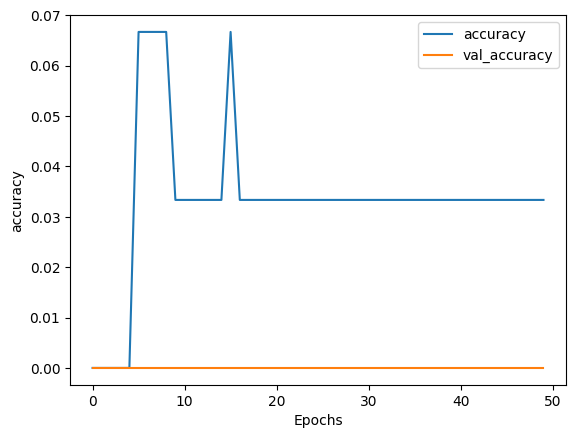

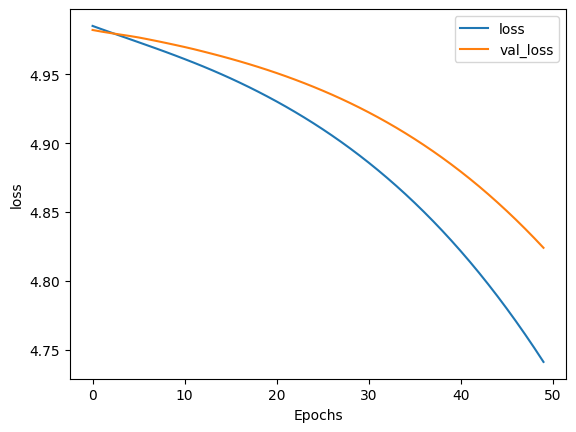

DECODE sentence
muốn đi sóc trăng quá à ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Original sentence
Muốn đi sóc Trăng quá à
City:
60
[[ 0.06530258 -0.07765453  0.05441543 ... -0.03462917 -0.03895647
   0.08803187]
 [-0.03266219  0.04149706 -0.03496978 ... -0.003444   -0.00366556
  -0.01133633]
 [ 0.06153248 -0.02618689  0.02712517 ... -0.05340714 -0.02736541
  -0.01408214]
 ...
 [-0.02584137 -0.03852408 -0.02964544 ... -0.02482443  0.04922484
  -0.02827185]
 [ 0.02360204  0.00244771  0.04848799 ...  0.04134395  0.01979107
  -0.00669625]
 [ 0.02585207 -0.0352523  -0.01975003 ... -0.04223055  0.04078246
   0.00403937]]


In [331]:
import matplotlib.pyplot as plt


def plot_graphs(history, str):
    plt.plot(history.history[str])
    plt.plot(history.history["val_" + str])
    plt.xlabel("Epochs")
    plt.ylabel(str)
    plt.legend([str, "val_" + str])
    plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# decode the word index back to original word
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


def decode_sentences(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])


print("DECODE sentence")
print(decode_sentences(training_padded[0]))
print("Original sentence")
print(training_sentences[0])
print("City:")
print(labels[0])

e = model.layers[0]
weights = e.get_weights()[0]
print(weights)  # shape: (vocab_size, embedding_dim)

## 8. Saving the model

In [332]:
# Saving the whole model
# HDF5 format
model.save("nn.h5")
# Saving only weight
model.save_weights("nn_weight.h5")
# Saving only the architecture
json_str = model.to_json()
with open("nn_model.json", "w") as f:
    f.write(json_str)

d:\#Code\My Project\Test\JupiterNotebook\bus_ticket_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 9. Predict data using pre-trained model

In [341]:
# Data to predict
sentences = ["Sóc"]

pretrain_model = tf.keras.models.load_model("nn.h5")
# pretrain_model.summary()

sequences = tokenizer.texts_to_sequences(sentences)
padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type
)
print(padded)
prediction = pretrain_model.predict(padded)
maxIndex = np.argmax(prediction[0])
max = np.max(prediction[0])
print(PROVINCES_DICT[maxIndex], max)

[[71  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
1/1 [==============================] - 0s 43ms/step
tỉnh đồng nai 0.26098114
